Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [125]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [126]:
import matplotlib.pyplot as plot
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (51909, 28, 28) (51909,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (51909, 784) (51909, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
#logistic regression with regularization
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    #dada
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size));
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels));
    regularization_factor = tf.placeholder(tf.float32);
    tf_valid_dataset = tf.constant(valid_dataset);
    tf_test_dataset = tf.constant(test_dataset);
    
    #Variables(weights and biases)
    weights = tf.Variable(tf.truncated_normal([image_size*image_size,num_labels]));
    biases = tf.Variable(tf.zeros(num_labels));
    
    #training computations
    regularization = tf.nn.l2_loss(weights);
    logits = tf.matmul(tf_train_dataset,weights) + biases;
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))+ (regularization_factor*regularization);
    
    #optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss);
    
    #predictions
    train_prediction = tf.nn.softmax(logits);
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset,weights)+biases);
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset,weights)+biases);
    

In [8]:
#run and evaluate
num_steps = 3001
regularizators = [pow(10,i) for i in np.arange(-4, -0.1, 0.1)];
train_accuracy = [];
valid_accuracy = [];
test_accuracy = [];

for regul_factor in regularizators:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run();
        print("Initialized for reg:"+str(regul_factor));

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size);
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset:batch_data,tf_train_labels:batch_labels , regularization_factor : regul_factor };
            _,l,predictions =  session.run([optimizer,loss,train_prediction],feed_dict= feed_dict);

        print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels));
        valid_accuracy.append(accuracy(
                valid_prediction.eval(), valid_labels));
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels));
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels));

Initialized for reg:0.0001
Validation accuracy: 80.0%
Test accuracy: 86.7%
Initialized for reg:0.000125892541179
Validation accuracy: 79.3%
Test accuracy: 86.7%
Initialized for reg:0.000158489319246
Validation accuracy: 80.2%
Test accuracy: 86.9%
Initialized for reg:0.000199526231497
Validation accuracy: 80.2%
Test accuracy: 87.3%
Initialized for reg:0.000251188643151
Validation accuracy: 80.4%
Test accuracy: 87.2%
Initialized for reg:0.000316227766017
Validation accuracy: 80.5%
Test accuracy: 87.6%
Initialized for reg:0.000398107170553
Validation accuracy: 81.1%
Test accuracy: 88.1%
Initialized for reg:0.000501187233627
Validation accuracy: 81.7%
Test accuracy: 88.3%
Initialized for reg:0.00063095734448
Validation accuracy: 81.8%
Test accuracy: 88.3%
Initialized for reg:0.000794328234724
Validation accuracy: 82.1%
Test accuracy: 88.6%
Initialized for reg:0.001
Validation accuracy: 82.2%
Test accuracy: 89.0%
Initialized for reg:0.00125892541179
Validation accuracy: 82.6%
Test accuracy:

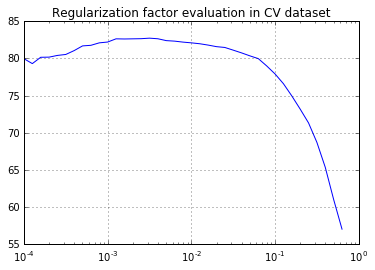

In [9]:
plot.semilogx(regularizators, valid_accuracy)
plot.grid(True)
plot.title('Regularization factor evaluation in CV dataset')
plot.show()

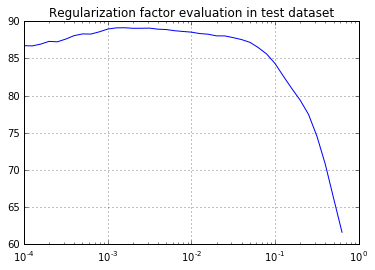

In [10]:
plot.semilogx(regularizators, test_accuracy)
plot.grid(True)
plot.title('Regularization factor evaluation in test dataset')
plot.show()

Regularization factor selected for logistic classifier: 0.00158489319246

In [11]:
#Neural newtork(relu hidden units) with regularization
batch_size = 128;
graph = tf.Graph();
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size));
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels));
    tf_validation_dataset = tf.constant(valid_dataset);
    tf_test_set = tf.constant(test_dataset);
    regularization_factor = tf.placeholder(tf.float32);
    
    #variables
    weights_layer1 = tf.Variable(tf.truncated_normal([image_size*image_size,1024]));
    biases_layer1 = tf.Variable(tf.zeros([1024]));
    
    #computaton of layer1
    logits_layer1 = tf.matmul(tf_train_dataset,weights_layer1)+biases_layer1;
    relus_output = tf.nn.relu(logits_layer1);
    
    #parametes layer2
    weights_layer2 = tf.Variable(tf.truncated_normal([1024,10]));
    biases_layer2 = tf.Variable(tf.zeros([10]));
    
    #computation layer2
    regularization = tf.nn.l2_loss(weights_layer1) + tf.nn.l2_loss(weights_layer2);
    logits_layer2  = tf.matmul(relus_output,weights_layer2)+biases_layer2;
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits_layer2,tf_train_labels)) + (regularization_factor*regularization) ;
    
    #optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss);
    
    #predictions
    train_prediction = tf.nn.softmax(logits_layer2);
    validation_relus_output = tf.nn.relu(tf.matmul(tf_validation_dataset,weights_layer1)+biases_layer1);
    validation_prediction  = tf.nn.softmax(tf.matmul(validation_relus_output,weights_layer2)+biases_layer2);
    test_relus_output = tf.nn.relu(tf.matmul(tf_test_set,weights_layer1)+biases_layer1);
    test_prediction = tf.nn.softmax(tf.matmul(test_relus_output,weights_layer2)+biases_layer2);
    

In [ ]:
num_steps = 3001
regularizators = [pow(10,i) for i in np.arange(-4,-0.1,0.1)]
train_accuracy = [];
valid_accuracy = [];
test_accuracy = [];

for regul_factor in regularizators:
    with tf.Session(graph = graph) as session:
        tf.initialize_all_variables().run();
        print("Initialized variables for reg factor:"+str(regul_factor));
        
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size);
            batch_data = train_dataset[offset:(offset + batch_size), :];
            batch_labels = train_labels[offset:(offset + batch_size), :];
            feed_dict = {tf_train_dataset:batch_data,tf_train_labels:batch_labels,regularization_factor:regul_factor};
            _,l,predictions = session.run([optimizer,loss,train_prediction],feed_dict = feed_dict);
        
        print("Validation accuracy: %.1f%%" % accuracy(
                validation_prediction.eval(), valid_labels));
        valid_accuracy.append(accuracy(
                validation_prediction.eval(), valid_labels));
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels));
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels));

Initialized variables for reg factor:0.0001
Validation accuracy: 82.5%
Test accuracy: 89.6%
Initialized variables for reg factor:0.000125892541179
Validation accuracy: 82.9%
Test accuracy: 89.6%
Initialized variables for reg factor:0.000158489319246
Validation accuracy: 83.0%
Test accuracy: 90.1%
Initialized variables for reg factor:0.000199526231497
Validation accuracy: 81.6%
Test accuracy: 88.3%
Initialized variables for reg factor:0.000251188643151
Validation accuracy: 83.6%
Test accuracy: 90.5%
Initialized variables for reg factor:0.000316227766017
Validation accuracy: 83.4%
Test accuracy: 90.0%
Initialized variables for reg factor:0.000398107170553
Validation accuracy: 83.5%
Test accuracy: 90.6%
Initialized variables for reg factor:0.000501187233627
Validation accuracy: 83.8%
Test accuracy: 90.5%
Initialized variables for reg factor:0.00063095734448
Validation accuracy: 85.0%
Test accuracy: 91.5%
Initialized variables for reg factor:0.000794328234724
Validation accuracy: 85.6%
Tes

In [ ]:
plot.semilogx(regularizators, valid_accuracy)
plot.grid(True)
plot.title('Regularization factor evaluation in CV dataset')
plot.show()

In [ ]:
plot.semilogx(regularizators, test_accuracy)
plot.grid(True)
plot.title('Regularization factor evaluation in test dataset')
plot.show()

Regularization factor chosed for neural network: 0.00158489319246

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [14]:
#i will use 20 batches with  a smaller training set



Variables initialized
Loss at step 0: 357.027527
Training accuracy: 3.9%
Validation accuracy: 31.2%
Test accuracy: 34.4%
Loss at step 1: 1626.959595
Training accuracy: 30.5%
Validation accuracy: 42.9%
Test accuracy: 46.4%
Loss at step 2: 1160.976074
Training accuracy: 46.1%
Validation accuracy: 32.5%
Test accuracy: 34.9%
Loss at step 3: 1062.342163
Training accuracy: 32.8%
Validation accuracy: 42.4%
Test accuracy: 45.6%
Loss at step 4: 540.718018
Training accuracy: 55.5%
Validation accuracy: 51.9%
Test accuracy: 56.0%
Loss at step 5: 272.812805
Training accuracy: 57.0%
Validation accuracy: 59.6%
Test accuracy: 65.9%
Loss at step 6: 65.631401
Training accuracy: 78.9%
Validation accuracy: 63.4%
Test accuracy: 69.6%
Loss at step 7: 77.229950
Training accuracy: 75.8%
Validation accuracy: 65.8%
Test accuracy: 72.5%
Loss at step 8: 53.663086
Training accuracy: 84.4%
Validation accuracy: 64.1%
Test accuracy: 70.0%
Loss at step 9: 52.185905
Training accuracy: 85.2%
Validation accuracy: 68.3%
T

We can conclude theres overfitting watching that training accuracy is 100% but validation is smaller.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [30]:
batch_size = 128;
graph = tf.Graph();
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size));
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels));
    tf_validation_dataset = tf.constant(valid_dataset);
    tf_test_set = tf.constant(test_dataset);
    
    weights_layer1=tf.Variable(tf.truncated_normal([image_size*image_size,1024]));
    biases_layer1 = tf.Variable(tf.zeros([1024]));
    
    logits_layer1 = tf.matmul(tf_train_dataset,weights_layer1)+biases_layer1;
    relus_output = tf.nn.relu(logits_layer1);
    
    dropout_layer = tf.nn.dropout(relus_output,0.5);
    
    weights_layer2 = tf.Variable(tf.truncated_normal([1024,10]));
    biases_layer2 = tf.Variable(tf.zeros([10]));
    
    #regularization = tf.nn.l2_loss(weights_layer1) + tf.nn.l2_loss(weights_layer2);
    logits_layer2 = tf.matmul(dropout_layer,weights_layer2)+biases_layer2;
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_layer2,tf_train_labels));
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss);
    
    train_prediction = tf.nn.softmax(logits_layer2);
    
    validation_relus_output = tf.nn.relu(tf.matmul(tf_validation_dataset,weights_layer1)+biases_layer1);
    validation_prediction = tf.nn.softmax(tf.matmul(validation_relus_output,weights_layer2)+biases_layer2);
    
    test_relus_output = tf.nn.relu(tf.matmul(tf_test_set,weights_layer1)+biases_layer1);
    test_prediction = tf.nn.softmax(tf.matmul(test_relus_output,weights_layer2)+biases_layer2);

    

In [31]:
num_steps = 20;
reduced_dataset = train_dataset[:512,:];
reduced_labels = train_labels[:512];
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run();
    print("Variables initialized");
    
    for step in range(num_steps):
        offset = (step * batch_size) % (reduced_labels.shape[0] - batch_size);
        batch_data = reduced_dataset[offset:(offset + batch_size), :];
        batch_labels = reduced_labels[offset:(offset + batch_size), :];
        feed_dict = {tf_train_dataset:batch_data,tf_train_labels:batch_labels};
        _,l,predictions = session.run([optimizer,loss,train_prediction] ,feed_dict = feed_dict);
        
        print('Loss at step %d: %f' % (step, l))
        print('Training accuracy: %.1f%%' % accuracy(
        predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
                validation_prediction.eval(), valid_labels));
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels));

Variables initialized
Loss at step 0: 514.240417
Training accuracy: 10.2%
Validation accuracy: 24.9%
Test accuracy: 26.0%
Loss at step 1: 1383.257202
Training accuracy: 18.8%
Validation accuracy: 48.5%
Test accuracy: 52.9%
Loss at step 2: 1012.267578
Training accuracy: 48.4%
Validation accuracy: 31.4%
Test accuracy: 34.0%
Loss at step 3: 857.012146
Training accuracy: 35.2%
Validation accuracy: 52.4%
Test accuracy: 56.9%
Loss at step 4: 594.158569
Training accuracy: 60.2%
Validation accuracy: 58.8%
Test accuracy: 64.3%
Loss at step 5: 403.382996
Training accuracy: 68.0%
Validation accuracy: 62.1%
Test accuracy: 67.5%
Loss at step 6: 178.142731
Training accuracy: 76.6%
Validation accuracy: 66.1%
Test accuracy: 71.9%
Loss at step 7: 135.503860
Training accuracy: 75.8%
Validation accuracy: 69.2%
Test accuracy: 75.1%
Loss at step 8: 91.676674
Training accuracy: 74.2%
Validation accuracy: 66.0%
Test accuracy: 72.0%
Loss at step 9: 102.950447
Training accuracy: 80.5%
Validation accuracy: 70.0

It helped but just a little bit, maybe it would give better results on bigger networks

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


### Ill try with 4 layer network

In [108]:
batch_size = 128
layer1_units = 1024;
layer2_units = 300;
layer3_units = 50;
output_layer_units = num_labels;
regularization_factor = 1e-5

deep_graph = tf.Graph()
with deep_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size));
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels));
    tf_validation_dataset = tf.constant(valid_dataset);
    tf_test_set = tf.constant(test_dataset);
    
    # hidden layer 1
    weights_layer1=tf.Variable(tf.truncated_normal([image_size*image_size,layer1_units],stddev=np.sqrt(2.0/784)));
    biases_layer1 = tf.Variable(tf.zeros([layer1_units]));
    logits_layer1 = tf.matmul(tf_train_dataset,weights_layer1)+biases_layer1;
    relus_layer1 = tf.nn.relu(logits_layer1);
    hidden_layer1 = tf.nn.dropout(relus_layer1,0.5)
  
    # hidden layer 2
    weights_layer2 = tf.Variable(tf.truncated_normal([layer1_units,layer2_units],stddev=np.sqrt(2.0/layer1_units)));
    biases_layer2 = tf.Variable(tf.zeros([layer2_units]));
    logits_layer2 = tf.matmul(hidden_layer1,weights_layer2)+biases_layer2;
    relus_layer2 = tf.nn.relu(logits_layer2);
    hidden_layer2 = tf.nn.dropout(relus_layer2,0.7);
  
    # hidden layer 3
    weights_layer3 = tf.Variable(tf.truncated_normal([layer2_units,layer3_units],stddev=np.sqrt(2.0/layer2_units)));
    biases_layer3 = tf.Variable(tf.zeros([layer3_units]));
    logits_layer3 = tf.matmul(hidden_layer2,weights_layer3)+biases_layer3;
    relus_layer3 = tf.nn.relu(logits_layer3);
    hidden_layer3 = tf.nn.dropout( relus_layer3, 0.8)
  
    # output layer
    weights_output_layer = tf.Variable(tf.truncated_normal([layer3_units,output_layer_units],stddev=np.sqrt(2.0/layer3_units)));
    biases_output_layer = tf.Variable(tf.zeros([output_layer_units]));
    logits_output_layer = tf.matmul(hidden_layer3,weights_output_layer)+biases_output_layer;
    

    # Apply regularization
    regularization = tf.nn.l2_loss(weights_layer1)+tf.nn.l2_loss(weights_layer2)+tf.nn.l2_loss(weights_layer3)+tf.nn.l2_loss(weights_output_layer);
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_output_layer, tf_train_labels)) + (regularization_factor*regularization)
  
    # Use learning rate decay on gradient descent
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    train_prediction = tf.nn.softmax(logits_output_layer)

    # Setup validation prediction step.
    validation_hidden_layer_1 = tf.nn.relu(tf.matmul(tf_validation_dataset, weights_layer1) + biases_layer1)
    validation_hidden_layer_2 = tf.nn.relu(tf.matmul(validation_hidden_layer_1, weights_layer2) + biases_layer2)
    validation_hidden_layer_3 = tf.nn.relu(tf.matmul(validation_hidden_layer_2, weights_layer3) + biases_layer3)
    validation_logits = tf.matmul(validation_hidden_layer_3, weights_output_layer) + biases_output_layer
    validation_prediction = tf.nn.softmax(validation_logits)

    # And setup the test prediction step.  
    test_hidden_layer_1 = tf.nn.relu(tf.matmul(tf_test_set, weights_layer1) + biases_layer1)
    test_hidden_layer_2 = tf.nn.relu(tf.matmul(test_hidden_layer_1, weights_layer2) + biases_layer2)
    test_hidden_layer_3 = tf.nn.relu(tf.matmul(test_hidden_layer_2, weights_layer3) + biases_layer3)
    test_logits = tf.matmul(test_hidden_layer_3, weights_output_layer) + biases_output_layer
    test_prediction = tf.nn.softmax(test_logits)

num_steps = 20000

with tf.Session(graph=deep_graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(validation_prediction.eval(), valid_labels))
    print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.660305
Minibatch accuracy: 7.0%
Validation accuracy: 17.2%
Minibatch loss at step 500: 0.669877
Minibatch accuracy: 80.5%
Validation accuracy: 84.6%
Minibatch loss at step 1000: 0.569788
Minibatch accuracy: 84.4%
Validation accuracy: 85.4%
Minibatch loss at step 1500: 0.596642
Minibatch accuracy: 82.8%
Validation accuracy: 86.4%
Minibatch loss at step 2000: 0.471508
Minibatch accuracy: 81.2%
Validation accuracy: 87.0%
Minibatch loss at step 2500: 0.494823
Minibatch accuracy: 83.6%
Validation accuracy: 87.2%
Minibatch loss at step 3000: 0.478123
Minibatch accuracy: 84.4%
Validation accuracy: 87.6%
Minibatch loss at step 3500: 0.626774
Minibatch accuracy: 84.4%
Validation accuracy: 87.6%
Minibatch loss at step 4000: 0.442804
Minibatch accuracy: 84.4%
Validation accuracy: 88.1%
Minibatch loss at step 4500: 0.297537
Minibatch accuracy: 92.2%
Validation accuracy: 88.1%
Minibatch loss at step 5000: 0.250226
Minibatch accuracy: 93.0%
Validation accuracy